# Messy Notebook where I try to analyze data from Zotero


## Imports, global variables and Zotero session


In [1]:
# --- Import ---
# Core
from pyzotero import zotero


from pathlib import Path
import numpy as np
import pandas as pd


from pandas import DataFrame
from pandas.core.series import Series

# Additional
import matplotlib.pyplot as plt
import colorcet
from pprint import pprint
from tqdm import tqdm
import datetime



# --- Settings ---


group_library_id = "5602981"


user_library_id = "8968938"  # From: https://www.zotero.org/settings/keys


library_type = "group"  # To access the shared library, otherwise for private "user"


api_key = "jTbkXBSx7Yv0GyOQU3its5Gb"



# Quick ANSI color code shortcurts


r = "\033[31m"


y = "\033[33m"


g = "\033[32m"


b = "\033[34m"


e = "\033[0m"



# Paths to save tmp Dataframes


path_to_dataframes = Path("..") / "data" / "Review_ML-RS-FPGA" / "Dataframes"


all_articles_df_pkl = (
    path_to_dataframes
    / f"all_articles_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pkl"
)


models_df_pkl = (
    path_to_dataframes
    / f"all_datapoints_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pkl"
)



# --- Zotero API initialization ---


zot = zotero.Zotero(group_library_id, library_type, api_key)


print(zot)

### Methods


In [2]:
# --- Quick lambda functions ---
from typing import Literal


get_total_in_dict_of_lists = lambda d: sum([len(d[tag]) for tag in d])
get_total_in_dict = lambda d: sum([d[tag] for tag in d])


# Transforms a dictionnary in a string format (with several lines with "<key>: <value>") in a Python dictionnary
def parse_string_to_dict(input_string):
    # Initialize an empty dictionary
    result_dict = {}

    # Split the input string by newlines
    lines = input_string.split("\n")

    # Iterate over each line
    for line in lines:
        # Split each line by the first occurrence of ': '
        if ": " in line:
            key, value = line.split(": ", 1)
            result_dict[key.strip()] = value.strip()

    return result_dict


# From get every Zotero items from a library and a list of items' keys
def fetch_articles_data(zot: zotero.Zotero, keys: list[str]):
    # Prepare a list to hold each article's data
    articles_data = []
    print(f"{y}Fetching data for {len(keys)} articles...{e}")

    for key in tqdm(keys):
        # Fetch the item data for each key
        data = zot.item(key)["data"]

        # Extract the relevant information
        title = data.get("title", "")
        doi = data.get("DOI", "")
        url = data.get("url", "")
        abstract_note = data.get("abstractNote", "")
        date = data.get("date", "")
        item_type = data.get("itemType", "")
        extra = parse_string_to_dict(data.get("extra", ""))

        # print(f" - {g}{title}{e}...")

        # Extract the list of authors
        authors = [
            f"{author['firstName']} {author['lastName']}"
            for author in data.get("creators", [])
            if author["creatorType"] == "author"
        ]

        # Extract the list of tags
        tags = [tag["tag"] for tag in data.get("tags", [])]

        # Append the data to the articles_data list
        articles_data.append(
            {
                "BBT Citation Key": extra["Citation Key"],
                "Title": title,
                "Authors": authors,
                "DOI": doi,
                "URL": url,
                "Tags": tags,
                "Abstract Note": abstract_note,
                "Date": date,
                "Item Type": item_type,
                "Zotero Key": key,
            }
        )

    # Create a DataFrame from the collected data
    df = pd.DataFrame(articles_data)
    df.set_index("BBT Citation Key", inplace=True)

    return df


# ---------------------------------- Article analysis ---------------------------------- #


# From the list of tags of an item, return 4 lists for each "Dataset", "Model", "Board" and "Task"
# I use it to detect if an item compares several models, possibly on several board/dataset/or even task
def parse_tags(tag_list):
    # Initialize a dictionary to hold the parsed information
    parsed_data = {
        "Board": [],
        "Implementation": [],
        "Models": [],
        "Datasets": [],
        "Tasks": [],
    }

    # Iterate over each tag in the list
    for tag in tag_list:
        if tag.startswith("Dataset:"):
            parsed_data["Datasets"].append(tag.split("Dataset: ")[1].strip())
        elif tag.startswith("Model:") and tag != "Model: N/A":
            parsed_data["Models"].append(tag.split("Model: ")[1].strip())
        elif tag.startswith("Board:"):
            parsed_data["Board"].append(tag.split("Board: ")[1].strip())
        elif tag.startswith("Task:"):
            parsed_data["Tasks"].append(tag.split("Task: ")[1].strip())
        elif tag.startswith("Implementation:"):
            parsed_data["Implementation"].append(
                tag.split("Implementation: ")[1].strip()
            )

    if len(parsed_data["Implementation"]) > 1:
        print(f"    Warning: Multiple Implementations detected for {b}{tag_list}{e}")
    if len(parsed_data["Board"]) > 1:
        print(f"    Warning: Multiple Boards detected for {b}{tag_list}{e}")
    return parsed_data


# The tags for the model name contain a lot of information A typical model_name is:
#  "<name used in the article> (<corresponding model>) {<backbone>}", each component is returned in a tuple
def parse_model_name(model_name: str) -> tuple[str, str, str] | Literal[-1]:
    # Initialize the components
    name_used_in_article = None
    corresponding_model = ""
    backbone = ""

    # Find the positions of the parentheses and curly braces
    paren_start: int = model_name.find("(")
    paren_end: int = model_name.find(")")
    brace_start: int = model_name.find("{")
    brace_end: int = model_name.find("}")

    # If any of the parentheses or curly braces are missing, leave the function
    if (paren_start == -1 and paren_end != -1) or (
        paren_start != -1 and paren_end == -1
    ):
        print(
            f"    Warning: {b}{model_name}{e} is not in the expected format for the model name. Parentheses are missing."
        )
        return -1

    # Extract the name used in the article
    name_used_in_article: str = model_name[:paren_start].strip()
    # Extract the corresponding model and the backbone
    corresponding_model: str = model_name[paren_start + 1 : paren_end].strip()
    if corresponding_model == "":
        corresponding_model = name_used_in_article
    backbone: str = model_name[brace_start + 1 : brace_end].strip()

    return name_used_in_article, corresponding_model, backbone


# Extract all the systematically reported performance metric (latency, task score (aka, performance), model size, throuput and power)
# from <item> which is the row of the Dataframe. If a metric is missing, it gets printed
# Choice has been made to set the 'N/A' value to a blank space ' ' (for clarity when printing)
def extract_metrics_from_df_row(item, model_name=""):
    # print(f'model_name: "{b}{model_name}{e}"')
    if model_name != "":
        # Parse the model_name in the 3 components, e.g., A typical model_name is "<name used in the article> (<corresponding model>) {<backbone>}"
        # Each model_name contains at least the field with the brackets {} and the field without anything, the parenthesis field is bonus
        # Example "Improved YOLOv4-tiny 3L (YOLOv4-tiny) {Darkent53-tiny}"
        model_name, corresponding_model, backbone = parse_model_name(model_name)

    # List of possible metrics to look for
    metrics_keys = [
        "Model latency: ",  # in ms or FPS
        "Model performance: ",  # in % Acc, $ mIoU, etc.
        "Model size: ",  # in MB
        "Model throughput: ",  # in OP/s
        "Power consumption: ",  # in W
    ]

    # Initialize an empty dictionary to store the found metrics
    metrics_dict = {}
    missing_metrics = []

    # Iterate through each metric key to ensure all are checked
    for key in metrics_keys:
        found = False
        for tag in item["Tags"]:

            # Check for the no-parenthesis syntax (Case 1, 3 or 4)
            if tag.startswith(key) and model_name == "":
                metric_value = tag.split(key)[1].strip()
                metric_value = "" if metric_value.startswith("N/A") else metric_value
                metrics_dict[key[:-2]] = metric_value
                found = True
                break

            # Check for the parenthesis syntax (Case 2, 5 or 6)
            # The name within the parenthesis is either the model_name (used in the article) or the backbone
            elif tag.startswith(f"{key}(") and model_name != "":
                model_name_in_tag = tag[len(key) :].split(")")[0][1:].strip()
                if model_name_in_tag == model_name or model_name_in_tag == backbone:
                    # print(
                    #     f"model_name_in_tag: {b}{model_name_in_tag}{e} and model_name: {r}{model_name}{e} and backbone: {r}{backbone}{e}"
                    # )
                    metric_value = tag.split(")")[1].strip()
                    metrics_dict[key[:-2]] = metric_value
                    found = True
                    break

        # print(f"{g}{key}{e}")
        if found and key == "Model performance: ":
            print(f"{key[:-2]} for {b}{model_name}{e}: {g}{metrics_dict[key[:-2]]}{e}")
            if "Acc" in metrics_dict[key[:-2]]:
                print(f"identified Acc/OA metric, replacing it by OA")
                metrics_dict[key[:-2]] = metrics_dict[key[:-2]].replace("Acc", "OA")

        # If the metric was not found, set its value to '' and print a message
        if not found:
            metric_name_clean = key[:-2]  # Clean up the metric name for display
            metrics_dict[metric_name_clean] = ""
            missing_metrics.append(metric_name_clean)

    # Print missing metrics if any
    if missing_metrics:
        print(
            f"    Warning: {b}{item['Title']}{e} misses: {r}{', '.join(missing_metrics)}{e} metrics for model {b}{model_name}{e}."
        )

    return metrics_dict

## Bonus: Playing with the API


#### Print all collections


In [3]:
# collections = zot.all_collections()
# print(len(collections), "collections in your library")
# pprint(collections)

#### Get every possible item


In [4]:
# # Zotero.everything() leverages the 100 items per request limit
# all_items = zot.everything(zot.top())
# # I have ~310 items and it takes 20s to fetch them all
# print(len(all_items), "items in your library")

#### See which possible `itemTypes` are available


In [5]:
# pprint(len(zot.item_types()))

## Access to the review collection

Key for my private user library, the `"PhD - DLR"`/`"On-board AI"`/`"Review ML / FPGA / RS"`/`"Merge with already read"` library:

- `"LWR4HAWY"`

Key for the shared library, `"included in review"`:

- `"PEWYQYGG"`


In [6]:
# Add search paprameters to select only conference papers and journal articles
# /!\ Ideally i just want to NOT select notes and attachments, but I did not find the API syntax to do so
zot.add_parameters(itemType="conferencePaper || journalArticle")
# Fetch all the items in the library (Without the limitation of 100 items per request)
# Key of the group "included in review" collection: PEWYQYGG, and key of my private user collection: LWR4HAWY
review_items = zot.everything(zot.collection_items("PEWYQYGG"))
print(len(review_items), " items in the review collection")

43  items in the review collection


### Sort articles if selected or not

All articles in the sub-collection should include the tag "ML-FPGA Review" and not have the "Outside the scope of the review" or any "Excluded: " tag.
Nevertheless, double checking doesn't hurt. 🙃


In [7]:
excluded = {}
articles_selected_for_review = []
# --- For all item ---
for item in tqdm(review_items):
    # Print the item's title and type
    # print(f"{r}{item['data']['itemType']}{e}")
    # print(f" - {b}{item['data']['title']}{e}")

    # print(f'Item Type: {item["data"]["itemType"]} | Key: {item["data"]["key"]}')
    # Get the item's tags as a list
    tags = item["data"].get("tags", [])
    is_excluded = False
    for tag in tags:
        # Weird but each tag is a dictionary with a "tag" key
        tag = tag["tag"]
        # If the tag starts with "excluded: "
        if tag.startswith("Excluded: "):
            # If the tag is not yet in the excluded dictionary
            if tag not in excluded:
                # Add the tag as a key and an empty list as the value
                excluded[tag] = []

            # Add the item's key to the list of keys for the tag
            excluded[tag].append(item["data"]["key"])
            is_excluded = True
            break
    # If the item is not excluded, add its key to the list of keys for the tag "Selected for review"
    if not is_excluded:
        articles_selected_for_review.append(item["data"]["key"])

# Verify that the total of excluded items sum up to the total number of items in the review collection
total_excluded = 0
for key in excluded:
    total_excluded += len(excluded[key])

print(
    f"{r}{total_excluded}{e} excluded items + {g}{len(articles_selected_for_review)}{e} selected for review = {b}{len(review_items)}{e} total items in the review collection"
)
assert total_excluded + len(articles_selected_for_review) == len(review_items)


# Print the excluded dictionary
print(f"Total number of items excluded: {r}{total_excluded}{e}.")
for tag, keys in excluded.items():
    print(f'{r}{len(keys):>3}{e} items excluded for: {b}"{tag[10:]}"{e}')

100%|██████████| 43/43 [00:00<?, ?it/s]

0 excluded items + 43 selected for review = 43 total items in the review collection
Total number of items excluded: 0.


### Transform the data in a pandas `Dataframe`

After verifying that all the articles will be included in the review. Get the actual data of each item, and store it in a Dataframe.

Also, save the dataframe, if needed offline


In [8]:
# Fetch the data and create a DataFrame
selected_articles_df = fetch_articles_data(zot, articles_selected_for_review)
# pprint(selected_articles_df)

# Write the data (to work offline)
selected_articles_df.to_pickle(all_articles_df_pkl)
print(f"Dataframe with the original articles saved at: {all_articles_df_pkl}")

Fetching data for 43 articles...


100%|██████████| 43/43 [00:47<00:00,  1.11s/it]

Dataframe with the original articles saved at: ..\data\Review_ML-RS-FPGA\Dataframes\all_articles_2024-10-18_10-27-53.pkl


In [9]:
path = all_articles_df_pkl  # .parents[0] / "all_articles_2024-09-02_11-33-50.pkl"
selected_articles_df = pd.read_pickle(path)

## "Dataset" creation

This section creates a new dataframe where each item is one "datapoint", i.e., a model. Some articles report several models, some only report one.

Each article in the Dataframe has the following fields:

```
"BBT Citation Key", "Title", "Authors", "DOI", "URL", "Tags", "Abstract Note", "Date", "Item Type", "Zotero Key"
```

Because of the mess (the wide diversity of articles) in the tagging process I have to separate the different cases I can encounter here.


In [10]:
datapoints = []
articles_type_count = {  # Debug variable
    "Case 1": 0,
    "Case 2": 0,
    "Case 3": 0,
    "Case 4": 0,
    "Case 5": 0,
    "Case 6": 0,
    "Case 7": 0,
}

# For each article
for index, row in selected_articles_df.iterrows():
    parsed_data = parse_tags(row["Tags"])

    # @TODO: I will care about articles with many boards later, atm I just report them
    if "???" in parsed_data["Board"] or len(parsed_data["Board"]) > 1:
        # print(f"{b}{row['Title']}{e}: {parsed_data}")
        continue

    # -------------------------- Case 1 (basic): 1 model, 1 dataset (so 1 task), 1 board --------------------------
    if len(parsed_data["Models"]) == 1 and len(parsed_data["Datasets"]) == 1:
        model_name, model_equivalent, backbone = parse_model_name(
            parsed_data["Models"][0]
        )
        print(f"{parsed_data}")
        main_info = {
            "BBT Citation Key": index,
            "Model": model_name,
            "Equivalent model": model_equivalent,
            "Backbone": backbone,
            "Dataset": f"{parsed_data['Datasets'][0]}",
            "Task": parsed_data["Tasks"][0].split("(")[0].strip(),
            "Application": parsed_data["Tasks"][0].split("(")[1][:-1].strip(),
            "Board": parsed_data["Board"][0],
            "Implementation": parsed_data["Implementation"][0],
        }
        performance_metrics = extract_metrics_from_df_row(row, "")
        datapoints.append(main_info | performance_metrics)
        articles_type_count["Case 1"] += 1

        print(
            f"- (CASE 1) {b}{model_name}{e} on {b}{main_info['Dataset']}{e} with performance: {r}{list(performance_metrics.values())}{e}."
        )

    # -------------------------- Case 2 (comparison of different architectures): X models, 1 dataset (so 1 task), 1 board --------------------------
    elif (
        len(parsed_data["Models"]) > 1
        and len(parsed_data["Datasets"]) == 1
        and "???" not in parsed_data["Models"]
    ):
        print(
            f"{index}: Reports {r}{len(parsed_data['Models'])}{e} models: {b}{parsed_data['Models']}{e}"
        )
        for model in parsed_data["Models"]:
            model_name, model_equivalent, backbone = parse_model_name(model)
            main_info = {
                "BBT Citation Key": index,  # 'BBT Citation Key'
                "Model": model_name,
                "Equivalent model": model_equivalent,
                "Backbone": backbone,
                "Dataset": parsed_data["Datasets"][0],
                "Task": parsed_data["Tasks"][0].split("(")[0].strip(),
                "Application": parsed_data["Tasks"][0].split("(")[1][:-1].strip(),
                "Board": parsed_data["Board"][0],
                "Implementation": parsed_data["Implementation"][0],
            }
            performance_metrics = extract_metrics_from_df_row(row, model)
            print(
                f'    - Model "{b}{model_name}{e}" extracted with performances: {r}{list(performance_metrics.values())}{e}.'
            )

            datapoints.append(main_info | performance_metrics)

        articles_type_count["Case 2"] += 1

    # UNSEEN Case 3: 1 model, Y datasets (same task), 1 board => Some articles test their model
    # on different datasets, but I reported only the most common/famous dataset (@TODO ?)
    # UNSEEN Case 4, a same model for different tasks doesn't exist, if it happens, I will put several times the model tag

    # -------------------------- Case 5 (1 model for each dataset, possibly different tasks): X models, X datasets, 1 board --------------------------
    elif (
        len(parsed_data["Models"]) > 1
        and len(parsed_data["Datasets"]) == len(parsed_data["Models"])
        and "???" not in parsed_data["Models"]
    ):
        # Because so far I only have 1 article in this case, I will hardcode it
        if index == "yanAutomaticDeploymentConvolutional2022a":
            for model in parsed_data["Models"]:
                model_name, model_equivalent, backbone = parse_model_name(model)
                print(f"        {g}{model_name}{e}, {model}")
                # Manage object detection case (1 model: YOLO):
                if "YOLO" in model_name:
                    main_info = {
                        "BBT Citation Key": index,
                        "Model": model_name,
                        "Equivalent model": model_equivalent,
                        "Backbone": backbone,
                        "Dataset": "DOTAv1.0 {Object Detection}",
                        "Task": "Object detection",
                        "Application": "diverse",
                        "Board": parsed_data["Board"][0],
                        "Implementation": parsed_data["Implementation"][0],
                    }
                # Manage classification case (1 model: VGG16):
                else:
                    main_info = {
                        "BBT Citation Key": index,
                        "Model": model_name,
                        "Equivalent model": model_equivalent,
                        "Backbone": backbone,
                        "Dataset": "NWPU-RESISC45 {Classification}",
                        "Task": "Classification",
                        "Application": "Terrain type",
                        "Board": parsed_data["Board"][0],
                        "Implementation": parsed_data["Implementation"][0],
                    }
                performance_metrics = extract_metrics_from_df_row(row, model)
                print(
                    f'    - Model "{b}{model_name}{e}" extracted with performances: {r}{list(performance_metrics.values())}{e}.'
                )
                datapoints.append(main_info | performance_metrics)
            articles_type_count["Case 5"] += 1
        else:
            print(f"MANAGE CASE 5 for {r}{index}{e}")

    # -------------------------- Case 6: X models, Y datasets (several models for a same dataset), 1 board --------------------------
    elif (
        len(parsed_data["Models"]) > 1
        and len(parsed_data["Datasets"]) > 1
        and "???" not in parsed_data["Models"]
    ):
        # Because so far I only have 1 article in this case, I will hardcode it
        if index == "niAlgorithmHardwareCoOptimization2023":
            for model in parsed_data["Models"]:
                model_name, model_equivalent, backbone = parse_model_name(model)
                print(f"        {g}{model_name}{e}, {model}")
                # Manage object detection case (1 model: YOLO):
                if model_name.startswith("YOLO"):
                    main_info = {
                        "BBT Citation Key": index,
                        "Model": model_name,
                        "Equivalent model": model_equivalent,
                        "Backbone": backbone,
                        "Dataset": "DOTAv1.0 {Object Detection}",
                        "Task": "Object detection",
                        "Application": "diverse",
                        "Board": parsed_data["Board"][0],
                        "Implementation": parsed_data["Implementation"][0],
                    }
                # Manage classification case (2 models: VGG16 and ResNet-34):
                else:
                    main_info = {
                        "BBT Citation Key": index,
                        "Model": model_name,
                        "Equivalent model": model_equivalent,
                        "Backbone": backbone,
                        "Dataset": "NWPU-RESISC45 {Classification}",
                        "Task": "Classification",
                        "Application": "Terrain type",
                        "Board": parsed_data["Board"][0],
                        "Implementation": parsed_data["Implementation"][0],
                    }
                performance_metrics = extract_metrics_from_df_row(row, model)
                print(
                    f'    - Model "{b}{model_name}{e}" extracted with performances: {r}{list(performance_metrics.values())}{e}.'
                )
                datapoints.append(main_info | performance_metrics)
            articles_type_count["Case 6"] += 1
        else:
            print(f"MANAGE CASE 6 for {r}{index}{e}")

    # -------------------------- Case 7: Else case --------------------------
    else:
        print(
            f"(CASE 7): {r}{index}{e} nb models = {len(parsed_data['Models'])} and nb datasets = {len(parsed_data['Datasets'])}"
        )
        articles_type_count["Case 7"] += 1

print(f"{r}{articles_type_count}{e}, Total: {sum(articles_type_count.values())}")
datapoints_df = pd.DataFrame(datapoints)
# datapoints_df.set_index(["BBT Citation Key", "Model"], inplace=True)

# print(datapoints_df)

{'Board': ['Zynq US+ (ZU7EV) {ZCU104}'], 'Implementation': ['HLS (Vitis)'], 'Models': ['Deep Belief Network (Diverse) {}'], 'Datasets': ['Airport-Beach-Urban {Pixel classification}'], 'Tasks': ['Pixel classification (Anomaly detection)']}
Model performance for : 
- (CASE 1) Deep Belief Network on Airport-Beach-Urban {Pixel classification} with performance: ['5.4 ms', '', '', '', ''].
{'Board': ['Zynq 7000 (Z7020) {PYNQ-Z1}'], 'Implementation': ['HLS (Vivado)'], 'Models': ['CNN () {}'], 'Datasets': ['DAC 2018 {Object Detection}'], 'Tasks': ['Object detection (diverse)']}
Model performance for : 21% mIoU
- (CASE 1) CNN on DAC 2018 {Object Detection} with performance: ['7 FPS', '21% mIoU', '', '69.8 GOP/s', '2.38 W'].
{'Board': ['Zynq US+ (ZU3EG) {Ultra96}'], 'Implementation': ['RTL design (N/A)'], 'Models': ['AP2D-Net (CNN) {}'], 'Datasets': ['Custom (UAV) {Object Detection}'], 'Tasks': ['Object detection (diverse)']}
Model performance for : 55.0% mIoU
- (CASE 1) AP2D-Net on Custom (UAV)

In [11]:
print(datapoints_df)

                                     BBT Citation Key  \
0                       boyleHighlevelFPGADesign2023a   
1     wangAccelerationImplementationConvolutional2019   
2                          liNovelCNNBasedAP2DNet2020   
3                           liEdgeRealtimeObject2023a   
4             pitsisEfficientConvolutionalNeural2019a   
5                nerisFPGABasedImplementationCNN2022a   
6                nerisFPGABasedImplementationCNN2022a   
7                chellaswamyFPGAbasedRemoteTarget2024   
8                  yangLightweightDetectionMethod2023   
9               zhangAccurateLowlatencyEfficient2022a   
10                      yuImprovedLightweightDeep2024   
11              nguyenFPGASoCImplementationYOLOv42024   
12            ieracitanoExplainableEmbeddedNeural2024   
13              zhangExtremelyPipelinedFPGAbased2023a   
14                  yangAlgorithmHardwareCodesign2022   
15                  yangAlgorithmHardwareCodesign2022   
16                  yangAlgorit

In [12]:
datapoints_df.to_pickle(models_df_pkl)
# datapoints_df = pd.read_pickle(name_models_df_pkl)

## Analysis


### Analyzing the number of missing metrics per paper


In [13]:
def is_undefined(str) -> bool:
    return str.startswith("N/A") or str.startswith("???") or str == ""


# --- # Quick check if any of the main information is missing ---
for index, row in datapoints_df.iterrows():

    if is_undefined(row["Model"]):
        print(f"Item N°{b}{index}{e} has no Model")
    if is_undefined(row["Dataset"]):
        print(f"Item N°{b}{index}{e} has no Dataset")
    if is_undefined(row["Board"]):
        print(f"Item N°{b}{index}{e} has no Board")
    if is_undefined(row["Task"]):
        print(f"Item N°{b}{index}{e} has no Task")

# --- Compute the number of missing (performance) metrics for each model ---
# Add a column to the dataframe with the number of missing metrics
datapoints_df["Missing metrics"] = datapoints_df.apply(
    lambda row: sum(
        [
            is_undefined(row[metric])
            for metric in [
                "Model latency",
                "Model performance",
                "Model size",
                "Model throughput",
                "Power consumption",
            ]
        ]
    ),
    axis=1,
)
# Print only the 'BBT Citation Key' and the missing metrics, only if there is more than 3 missing metrics
print(
    datapoints_df[datapoints_df["Missing metrics"] >= 4][
        ["BBT Citation Key", "Missing metrics"]
    ]
)


# --- Print the most missing metrics (for each metric) ---
for metric in [
    "Model latency",
    "Model performance",
    "Model size",
    "Model throughput",
    "Power consumption",
]:
    missing_metrics = 0
    for index, row in datapoints_df.iterrows():
        if is_undefined(row[metric]):
            missing_metrics += 1

    # Print the number of models missing the metric
    print(f"{r}{missing_metrics}{e} models miss the {b}{metric}{e} metric.")

                             BBT Citation Key  Missing metrics
0               boyleHighlevelFPGADesign2023a                4
5        nerisFPGABasedImplementationCNN2022a                4
6        nerisFPGABasedImplementationCNN2022a                4
7        chellaswamyFPGAbasedRemoteTarget2024                4
26         torresCombinedWeightlessNeural2020                4
27            myojinDetectingUncertainBNN2020                4
29  matos-carvalhoStaticDynamicAlgorithms2019                4
35  hammoudArtificialNeuralNetworksBased2022a                4
44           shibiOnboardTargetDetection2021a                5
45        martinsRealtimeSVMbasedHardware2024                4
9 models miss the Model latency metric.
6 models miss the Model performance metric.
28 models miss the Model size metric.
32 models miss the Model throughput metric.
15 models miss the Power consumption metric.


### Get general statistics

#### Implementation means

Typical implementation tags look like `'RTL design (VHDL)'` or `'Vitis AI (1.4)'`.
When grouping them by "family" I discard information about language or version.


In [56]:
# --- Initial raw count of the tags ---
impl_counts = datapoints_df["Implementation"].value_counts()
print(impl_counts)



# -- Group by "family", i.e., discard version or language information in between parenthesis ---

def determine_impl_group(index: str) -> str:

    return index.split("(")[0].strip()



# Map the series index to the new groups

impl_means_grouped = impl_counts.groupby(determine_impl_group).sum()

print(impl_means_grouped.sort_values(ascending=False))

Implementation
RTL design (VHDL)       11
N/A                      7
RTL design (Verilog)     7
HLS (Vitis)              6
RTL design (N/A)         6
HLS (FINN)               4
Vitis AI (DNNDK)         4
HLS (N/A)                3
Vitis AI (N/A)           2
RTL design (XSG)         2
HLS (Vivado)             1
Vitis AI (v1.4)          1
HLS (VGT)                1
Vitis AI (v2.5)          1
Name: count, dtype: int64
Implementation
RTL design    26
HLS           15
Vitis AI       8
N/A            7
Name: count, dtype: int64


### Board types

A typical board tag looks like that: `'Zynq 7000 (Z7020) {Arty Z7}'`: `'<family> (<model>) {<evaluation board>}'`.

The following cell groups the board by these 3 criteria.


In [55]:
# Print the number of model for each "Board" type
board_counts = datapoints_df["Board"].value_counts()
# A typical board tag looks like that: 'Zynq 7000 (Z7020) {Arty Z7}': '<family> (<model>) {<evaluation board>}'


# -- Group by "family", i.e., discard model in between parenthesis and evaluation board in between brackets ---
def determine_board_family_group(index: str) -> str:
    return index.split("(")[0].strip()


board_fam_grouped = board_counts.groupby(determine_board_family_group).sum()
print(board_fam_grouped.sort_values(ascending=False))


# -- Group by "board specific model", i.e., discard family and evaluation name in between brackets ---
def determine_board_model_group(index: str) -> str:
    if (
        index.count("(") == 0
    ):  # Some tags have no parenthesis (should be changed soon) @TODO
        return index.split("{")[0].strip()
    return index.split("(")[1].split("{")[0].strip()[:-1]


board_model_grouped = board_counts.groupby(determine_board_model_group).sum()
# print(board_model_grouped.sort_values(ascending=False))


# -- Group by "evaluation board" (the name in between curly braces) ---
def determine_board_eval_group(index: str) -> str:
    if index.count("{") == 0:
        return "AC701"  # One tag has a typo (should be changed soon) @TODO
    eval_board: str = index.split("{")[1][:-1].strip()
    return eval_board if eval_board else "N/A   "


board_eval_grouped = board_counts.groupby(determine_board_eval_group).sum()
# print(board_eval_grouped.sort_values(ascending=False))

Board
Zynq US+      20
Zynq 7000     13
Virtex-7      10
Artix-7        4
Kintex US      2
Kintex-7       2
Virtex-6       2
Alveo U280     1
Cyclone V      1
Spartan-3A     1
Name: count, dtype: int64
Board
VX690T        10
Z7020          9
ZU3EG          8
ZU7EV          6
ZU9EG          3
ZU15EG         3
Z7045          2
XCKU040        2
XC7K325T       2
XC7A35T        2
XC7A200T       2
VLX240T        2
5CSXC6         1
Z7035          1
Z7100          1
XC3SD1800A     1
               1
Name: count, dtype: int64
Board
N/A                     14
VC709                    7
ZCU104                   5
UltraZed-EG              4
OVC3                     3
Alinx AXU15EG            3
PYNQ-Z1                  3
ZC706                    2
Z-turn                   2
AC701                    2
KCU105                   2
Arty-35T                 2
Kria KV260               1
Quad-FPGA                1
Ultra96                  1
KC705                    1
Avnet Spartan-3A DSP     1
Arty Z7     

### Model data

Model information are already split in 3 Series: `'Model'`, `'Equivalent model'` and `'Backbone'`.
I think grouping by `'Model'`, i.e., how the model is called in the article, makes no sense. However, even if `'Equivalent model'` is a subjective tag decide by myself, this conveys interressant information.
Same for `'Backbone'`.


In [16]:
# Print the number of models
model_counts = datapoints_df["Equivalent model"].value_counts()
print(model_counts)

backbone_counts = (
    datapoints_df["Backbone"].value_counts().rename(lambda x: "N/A" if x == "" else x)
)
# print(backbone_counts)

Equivalent model
CNN            13
Diverse        10
YOLOv2          6
GNN             3
SSD300-HW       3
YOLOv3          2
YOLOv4-tiny     2
YOLOv4          2
SVM             2
LeNet-5         2
MLP             2
VGG16           2
AlexNet         1
MobileNetv1     1
VGG11           1
SSD             1
ResNet-34       1
U-Net           1
IORN4           1
Name: count, dtype: int64


### Tasks and Datasets


In [17]:
ml_task_counts = datapoints_df["Task"].value_counts()
print(ml_task_counts)

dataset_counts = datapoints_df["Dataset"].value_counts()
print(dataset_counts)

Task
Classification          19
Object detection        18
Pixel classification    12
Segmentation             6
Regression               1
Name: count, dtype: int64
Dataset
University of Pavia {Pixel classification}    6
Potsdam {Segmentation}                        4
NWPU-RESISC45 {Classification}                4
DOTAv1.0 {Object Detection}                   4
MSTAR {Classification}                        4
SSDD {Object Detection}                       3
Multi-drone (custom) {Object Detection}       3
Custom (ALOS-2) {Classification}              2
Custom (UAV) {Pixel classification}           2
L8 Biome {Classification}                     2
AVIRIS-NG {Pixel classification}              2
DIOR {Object Detection}                       2
Custom (UAV) {Object Detection}               2
MASATI {Classification}                       2
Custom (UAV) {Classification}                 1
Simulated (RGB) {Object Detection}            1
Simulated (SAR) {Regression}                  1
Custom (AL

## Bar plot generation

I want to generate a few bar plots representing the Series computed during the general statistics analysis. this implies:

- Implementation means
- Board families
- Datasets, this should be a grouped bar plot where datasets are grouped by their task family, e.g., Classification, Segmentation, etc.
- Equivalent models
- Backbones

the idea is to use `matplotlib`, save the figures in the `results/Review_ML-RS-FPGA/general_statistics/` folder, upload them in the Overleaf project, finally I should use the `subcaption` see [this blog](https://latex-tutorial.com/subfigure-latex/) for the full motivation.


### Plotting functions

I will save my plotting code in functions with version numbers

#### Implementation means


In [53]:
def plot_impl_means_by_family_v1(impl_counts) -> None:
    # --- Create Pivot Table ---
    # Transform the implementation counts into a DataFrame with categories and subcategories
    data_list = []
    for index, value in impl_counts.items():
        main_category = index.split("(")[0].strip()
        sub_category = index.split("(")[1][:-1].strip() if "(" in index else "N/A"
        data_list.append([main_category, sub_category, value])

    df = pd.DataFrame(data_list, columns=["Category", "SubCategory", "Count"])
    df = df.sort_values(by=["Count"])

    # Pivot the DataFrame to get the correct format for plotting
    pivot_df = df.pivot(index="Category", columns="SubCategory", values="Count").fillna(
        0
    )

    # --- Sort ---
    # Sort the categories: Create a 'Total' column, sort by it then drop it
    pivot_df["Total"] = pivot_df.sum(axis=1)
    pivot_df = pivot_df.sort_values(by="Total", ascending=False)
    pivot_df = pivot_df.drop(columns=["Total"])

    # Manually sort pivot table columns (I could not find a way to sort them automatically)
    pivot_df = pivot_df[
        [
            "VHDL",
            "Verilog",
            "XSG",
            "Vitis",
            "FINN",
            "Vivado",
            "VGT",
            "DNNDK",
            "v1.4",
            "v2.5",
            "N/A",
        ]
    ]

    # --- Setup Plot ---
    # Define a Color Vision Deficiency friendly color palette, from: https://www.simplifiedsciencepublishing.com/resources/best-color-palettes-for-scientific-figures-and-data-visualizations
    # - Stacked bar chart color palette examples: -
    # Dark Blue #2066a8, Med Blue #3594cc, Light Blue #8cc5e3
    # Dark Red #a00000, Tall Poppy #af2c2c (homemade), Med Red #c46666, Light Red #d8a6a6
    # Dark Teal #1f6f6f, Med Teal #54alal, Light Teal #9fc8c8
    CB_color_cycle: list[str] = [
        "#2066a8",
        "#3594cc",
        "#8cc5e3",
        "#a00000",
        "#af2c2c",
        "#c46666",
        "#d8a6a6",
        "#1f6f6f",
        "#54a1a1",
        "#9fc8c8",
    ]

    # Adjust the color list to match the number of sub-categories
    colors: list[str] = CB_color_cycle[: len(pivot_df.columns) - 1] + [
        "#aaaaaa"
    ]  # Use gray for 'N/A' (Silver Chalice)
    # Plotting
    categories = pivot_df.index
    sub_categories = pivot_df.columns
    width = 0.8  # the width of the bars

    # --- Plot ---
    _, ax = plt.subplots()
    bottom = np.zeros(len(categories))

    for i, sub_category in enumerate(sub_categories):
        counts = pivot_df[sub_category].values
        color = (
            colors[i] if sub_category != "N/A" else "#aaaaaa"
        )  # Use gray for 'N/A' (Silver Chalice)
        p = ax.bar(
            categories, counts, width, label=sub_category, bottom=bottom, color=color
        )
        bottom += counts
        ax.bar_label(
            p,
            labels=[
                f"{sub_category}" if count > 0 else ""
                for count, category in zip(counts, categories)
            ],
            label_type="center",
        )

    # Add total count labels on top of each bar
    total_counts = pivot_df.sum(axis=1)
    for i, total in enumerate(total_counts):
        ax.text(i, total + 0.1, f"{int(total)}", ha="center", va="bottom")

    # Add horizontal dotted lines for the ticks of the vertical axis
    ax.yaxis.grid(True, linestyle="--", linewidth=0.2, color="#aaaaaa")

    ax.set_title("Implementation means by family")
    # ax.legend()

    plt.show()

In [149]:
def plot_boards_by_family_v1(board_counts) -> None:
    # --- Prepare Data ---
    def determine_board_family_group(index: str) -> str:
        return index.split("(")[0].strip()

    df = board_counts.groupby(determine_board_family_group).sum()

    # --- Manual Sort ---
    sort_order: list[str] = [
        "Zynq US+",
        "Zynq 7000",
        "Virtex-7",
        "Virtex-6",
        "Kintex US",
        "Kintex-7",
        "Artix-7",
        "Alveo U280",
        "Cyclone V",
        "Spartan-3A",
    ]
    df = df.reindex(sort_order)

    # --- Setup Plot ---
    # Define a Color Vision Deficiency friendly color palette
    CB_color_cycle: list[str] = [
        "#2066a8",
        "#8cc5e3",  # Blues for Zynq US+ and Zynq 7000
        "#a00000",
        "#c46666",  # Reds for Virtex-7 and Virtex-6
        "#2066a8",
        "#8cc5e3",  # Blues again for Kintex US and Kintex-7
        "#a00000",  # Red again for Artix-7
        "#1f6f6f",
        "#54a1a1",
        "#9fc8c8",  # Teals for diverse boards
    ]

    # Adjust the color list to match the number of categories
    from itertools import cycle

    # Define positions with gaps between groups
    positions = []
    gap = 0.7  # Define the gap size
    current_pos = 0
    for i, category in enumerate(sort_order):
        if i > 0 and category in ["Virtex-7", "Kintex US", "Artix-7", "Alveo U280"]:
            current_pos += gap
        positions.append(current_pos)
        current_pos += 1

    # Plotting
    width = 0.8  # the width of the bars
    fig, ax = plt.subplots()

    bars = ax.bar(positions, df.values, width, color=colors)

    # Add labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{int(height)}",
            ha="center",
            va="bottom",
        )

    ax.set_title("FPGA Boards by Family")

    # Set x-ticks to the positions with the corresponding labels
    ax.set_xticks(positions)
    ax.set_xticklabels(sort_order, rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks([])

    plt.show()

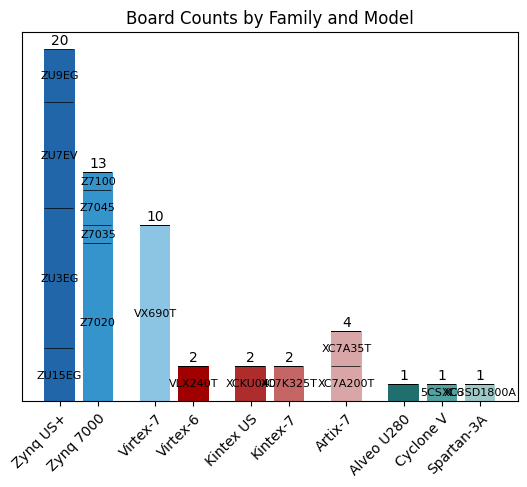

In [178]:
from itertools import cycle


def plot_boards_by_family_v2(board_counts) -> None:
    # --- Prepare Data ---
    def determine_board_family_group(index: str) -> str:
        return index.split("(")[0].strip()

    def determine_board_model(index: str) -> str:
        return index.split("(")[1].split(")")[0].strip()

    data_list = []
    for index, value in board_counts.items():
        family = determine_board_family_group(index)
        model = determine_board_model(index)
        data_list.append([family, model, value])

    df = pd.DataFrame(data_list, columns=["Family", "Model", "Count"])
    # Rename some of the models (make them shorter, etc.)
    model_mapping = {
        "ZU7EV": "7EV",
        "ZU15EG": "15EG",
        "ZU9EG": "9EG",
        "ZU3EG": "3EG",
        "Z7100": "7100",
        "Z7045": "7045",
        "Z7035": "7035",
        "Z7020": "7020",
        "VX690T": "690T",
        "VLX240T": "240T",
        # Add other mappings as needed
    }
    df["Model"] = df["Model"].replace(model_mapping)

    # Aggregate counts for each combination of Family and Model
    df = df.groupby(["Family", "Model"]).sum().reset_index()

    # --- Manual Sort ---
    sort_order = [
        "Zynq US+",
        "Zynq 7000",
        "Virtex-7",
        "Virtex-6",
        "Kintex US",
        "Kintex-7",
        "Artix-7",
        "Alveo U280",
        "Cyclone V",
        "Spartan-3A",
    ]
    df["Family"] = pd.Categorical(df["Family"], categories=sort_order, ordered=True)
    df = df.sort_values(by=["Family", "Model"])

    # Pivot the DataFrame to get the correct format for plotting
    pivot_df = df.pivot(index="Family", columns="Model", values="Count").fillna(0)

    # -- Sort by model (subcategories) --
    # @TODO

    # --- Setup Plot ---
    # Define a Color Vision Deficiency friendly color palette
    colors = [
        "#2066a8",
        "#3594cc",
        "#8cc5e3",  # Blues for Zynq US+ and Zynq 7000
        "#a00000",
        "#af2c2c",  # Reds for Virtex-7 and Virtex-6
        "#c46666",
        "#d8a6a6",  # Reds for Kintex US and Kintex-7
        "#1f6f6f",  # Teal for Artix-7
        "#54a1a1",
        "#9fc8c8",
        "#999999",  # Teals and gray for diverse boards
    ]
    # Define positions with gaps between groups
    positions = []
    gap = 0.5  # Define the gap size
    current_pos = 0
    for i, category in enumerate(sort_order):
        if i > 0 and category in ["Virtex-7", "Kintex US", "Artix-7", "Alveo U280"]:
            current_pos += gap
        positions.append(current_pos)
        current_pos += 1

    # Plotting
    families = pivot_df.index
    models = pivot_df.columns
    width = 0.8  # the width of the bars

    fig, ax = plt.subplots()
    bottom = np.zeros(len(families))

    for i, model in enumerate(models):
        counts = pivot_df[model].values
        p = ax.bar(positions, counts, width, label=model, bottom=bottom, color=colors)
        bottom += counts
        ax.bar_label(
            p,
            labels=[
                f"{model}" if count > 0 else ""
                for count, category in zip(counts, families)
            ],
            label_type="center",
            fontsize=8,
        )  # rotation=90,

    # Add total count labels on top of each bar
    total_counts = pivot_df.sum(axis=1)
    for pos, total in zip(positions, total_counts):
        ax.text(pos, total + 0.1, f"{int(total)}", ha="center", va="bottom")

    # Add horizontal lines between the models of each family
    for i, family in enumerate(families):
        count = 0
        for j, model in enumerate(models):
            count += pivot_df[model][family]
            ax.hlines(
                y=count,
                xmin=positions[i] - width / 2,
                xmax=positions[i] + width / 2 - 0.05,
                color="black",
                linewidth=0.5,
            )

    # Add horizontal dotted lines for the ticks of the vertical axis
    ax.yaxis.grid(True, linestyle="-", linewidth=0.5, color="gray")

    ax.set_title("Board Counts by Family and Model")

    # Rotate x-axis labels
    ax.set_xticks(positions)
    ax.set_xticklabels(sort_order, rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks([])

    plt.show()


plot_boards_by_family_v2(datapoints_df["Board"].value_counts())

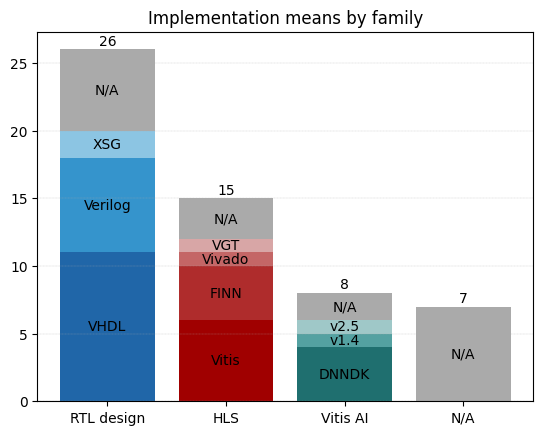

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 3 with shape (10,).

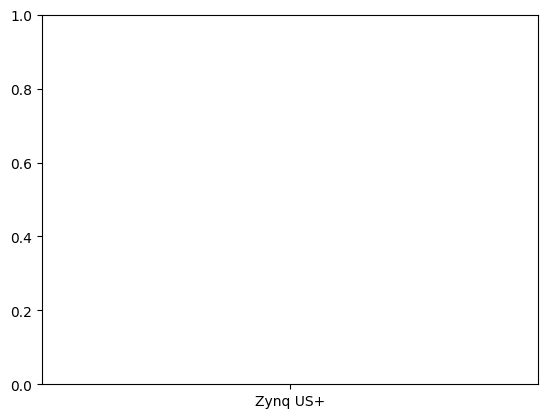

In [150]:
plot_impl_means_by_family_v1(datapoints_df["Implementation"].value_counts())

# print(datapoints_df["Board"].sort_values())
plot_boards_by_family_v2(datapoints_df["Board"].value_counts())

## Deeper analysis of common dataset and tasks among the dataframe

Check how many models (and paper) use the same datasets

About the mean of implementation on FPGA:

- 20 RTL design: 10 VHDL, 5 Verilog, 1 XSG (@TODO: what is that?) and 4 N/A
- 11 HLS: 3 Vitis, 1 Vivado, 3 FINN, 1 VGT (@TODO: classify with Vitis AI?) and 3 N/A
- 5 Vitis AI
- 6 N/A + 1 ??? (the review)


In [18]:
# For the first 4 datasets, print each model's name, the corresponding article research key and their metric
for dataset in dataset_counts.index[:8]:
    print(f"\n{b}{dataset}{e} dataset:")
    for index, row in datapoints_df.iterrows():
        if row["Dataset"] == dataset:
            print(
                f"    - {r}{row['Model']}{e} from {b}{row['BBT Citation Key']}{e} with board: {r}{row['Board']}{e} ({b}{row['Implementation']}{e}):"
            )
            print(
                f"        Score: {g}{row['Model performance']}{e}, Size: {g}{row['Model size']}{e}, Latency: {g}{row['Model latency']}{e}, Throughput: {g}{row['Model throughput']}{e}, Power: {g}{row['Power consumption']}{e}"
            )


University of Pavia {Pixel classification} dataset:
    - SAM-GNN from chellaswamyFPGAbasedRemoteTarget2024 with board: Virtex-7 (VX690T) {} (RTL design (VHDL)):
        Score: 95.05% OA, Size: , Latency: , Throughput: , Power: 
    - 2D CNN from heConfigurable2D3D2023a with board: Zynq US+ (ZU15EG) {Alinx AXU15EG} (RTL design (N/A)):
        Score: 98.24% OA, Size: 1.2 MB, Latency: 0.097 ms, Throughput: 7.07 GOP/s, Power: 8.4 W
    - 3D CNN from heConfigurable2D3D2023a with board: Zynq US+ (ZU15EG) {Alinx AXU15EG} (RTL design (N/A)):
        Score: 94.09% OA, Size: 0.12 MB, Latency: 1.11 ms, Throughput: 3.808 GOP/s, Power: 8.4 W
    - HybridSN from heConfigurable2D3D2023a with board: Zynq US+ (ZU15EG) {Alinx AXU15EG} (RTL design (N/A)):
        Score: 100% OA, Size: 20.5 MB, Latency: 7.71 ms, Throughput: 13.18 GOP/s, Power: 8.4 W
    - LPDBL from shibiOnboardTargetDetection2021a with board: Virtex-7 (VX690T) {} (RTL design (VHDL)):
        Score: , Size: , Latency: , Throughput: , Po

### Analyze common tasks


In [19]:
# For each Task, group by dataset and print each model name and backbones
for task, value in ml_task_counts.items():
    print(f"\n{b}{task}{e} task (total: {value}):")
    nb_item = 0
    for dataset in dataset_counts.index:
        if dataset.split("{")[1][:-1].strip().upper() == task.upper():
            print(f"    {b}{dataset.split('{')[0].strip()}{e}:")
            for index, row in datapoints_df.iterrows():
                if row["Task"] == task and row["Dataset"] == dataset:
                    print(
                        f"        - {r}{row['Model']}{e} ({row['Equivalent model']}) [{y}{row['Backbone']}{e}] from {b}{row['BBT Citation Key']}{e} with board: {r}{row['Board']}{e} ({row['Implementation']}):"
                    )
                    print(
                        f"            Score: {g}{row['Model performance']}{e}, Size: {g}{row['Model size']}{e}, Latency: {g}{row['Model latency']}{e}, Throughput: {g}{row['Model throughput']}{e}, Power: {g}{row['Power consumption']}{e}"
                    )
                    nb_item += 1

    print(f"    Total: {nb_item}")


Classification task (total: 19):
    NWPU-RESISC45:
        - ResNet-34 (ResNet-34) [ResNet-34] from niAlgorithmHardwareCoOptimization2023 with board: Virtex-7 (VX690T) {VC709} (RTL design (Verilog)):
            Score: 92.81% OA, Size: 21.29 MB, Latency: 40.2 ms, Throughput: 182 GOP/s, Power: 14.97 W
        - VGG16 (VGG16) [VGG16] from niAlgorithmHardwareCoOptimization2023 with board: Virtex-7 (VX690T) {VC709} (RTL design (Verilog)):
            Score: 91.90% OA, Size: 14.7 MB, Latency: 89.1 ms, Throughput: 344 GOP/s, Power: 14.97 W
        - Improved VGG16 (VGG16) [VGG16] from yanAutomaticDeploymentConvolutional2022a with board: Artix-7 (XC7A200T) (AC701) (RTL design (VHDL)):
            Score: 88.08% OA, Size: 14.8 MB, Latency: 1780 ms, Throughput: 40.96 GOP/s, Power: 3.41 W
        - Q-IORN (IORN4) [VGG16] from zhangEfficientFPGABasedImplementation2020 with board: Virtex-7 (VX690T) {VC709} (RTL design (VHDL)):
            Score: 88.31% OA, Size: 121.51 MB, Latency: 6.77 FPS, Thro

## Visualization of the Dataframe

Because the Dataframe is not in its best format in a cell output, you can use this section to play around with some filtering criteria and the `tabulate` package.


#### Classification


In [91]:
# --- Print the dataframe with only model trained for classification, sorted by dataset ---
from tabulate import tabulate


# Filter the dataframe to keep only the models trained for classification, having less than 4 missing metrics
classification_df: DataFrame = datapoints_df[datapoints_df["Task"] == "Classification"]
classification_df = classification_df[classification_df["Missing metrics"] < 4]
# Sort the dataframe by dataset
classification_df = classification_df.sort_values(by="Dataset")

# Print the dataframe with tabulate
print(
    tabulate(
        classification_df[
            [
                "BBT Citation Key",
                "Missing metrics",
                "Model",
                "Equivalent model",
                "Backbone",
                "Dataset",
                "Application",
                # "Board",
                # "Implementation",
                "Model latency",
                "Model performance",
                "Model size",
                "Model throughput",
                "Power consumption",
            ]
        ],
        headers="keys",
        tablefmt="pipe",
    )
)

|    | BBT Citation Key                                    |   Missing metrics | Model            | Equivalent model   | Backbone   | Dataset                                 | Application                      | Model latency   | Model performance   | Model size   | Model throughput   | Power consumption   |
|---:|:----------------------------------------------------|------------------:|:-----------------|:-------------------|:-----------|:----------------------------------------|:---------------------------------|:----------------|:--------------------|:-------------|:-------------------|:--------------------|
| 31 | hashimotoShipClassificationSAR2019a                 |                 3 | CNN              | CNN                |            | Custom (ALOS-2) {Classification}        | Binary ship classification       | 330 ms          | 100% OA             |              |                    |                     |
| 25 | rapuanoFPGAbasedHardwareAccelerator2021a            |             

## Old code from previous data format

Should not run anymore


### Analyze the Hardware

Which FPGA family, specific model and evaluation boards are used?


In [ ]:
# Print all tags
print(
    f"{r}{len(devices_tags)}{e} different device tags, in total {g}{get_total_in_dict_of_lists(devices_tags)}{e} tags:"
)
for tag, keys in devices_tags.items():
    print(f' - {r}{len(keys):>3}{e} items for {b}"{tag[7:]}"{e}')

# Leave out articles that have "Board: ???" or "Board: N/A"
# @TODO: Create a new dataframe per "datapoint", i.e., per experiment, so papers with several models or board will get as many datapoints

print(
    f"{r}{len(devices_families)}{e} different families, in total {g}{get_total_in_dict(devices_families)}{e}:"
)
for tag, keys in devices_families.items():
    print(f' - {r}{keys:>3}{e} items for {b}"{tag}"{e}')

print(
    f"{r}{len(devices_models)}{e} different models, in total {g}{get_total_in_dict(devices_models)}{e}:"
)
for tag, keys in devices_models.items():
    print(f' - {r}{keys:>3}{e} items for {b}"{tag}"{e}')

print(
    f"{r}{len(devices_boards)}{e} different boards/evaluation kits, in total {g}{get_total_in_dict(devices_boards)}{e}:"
)
for tag, keys in devices_boards.items():
    print(f' - {r}{keys:>3}{e} items for {b}"{tag}"{e}')

33 different device tags, in total 60 tags:
 -   1 items for "Virtex-6"
 -   1 items for "Kintex US rad-hard (XQRKU060)"
 -   1 items for "Zynq US+ (ZU7EV) {ZCU106}"
 -   1 items for "Zynq 7000 (Z7020) {PYNQ-Z2}"
 -   1 items for "Zynq US+ (ZU3EG) {UltraZed-EG}"
 -   3 items for "Virtex-7 (VX690T)"
 -   1 items for "Zynq US+ (ZU3EG) {OVC3}"
 -   1 items for "Zynq US+ (ZU9EG)"
 -   3 items for "Zynq 7000 (Z7020)"
 -   3 items for "Virtex-7 (VX690T) {VC709}"
 -   2 items for "Zynq 7000 (Z7020) {Zedboard}"
 -   1 items for "Artix-7 (XC7A35T) {Arty-35T}"
 -   1 items for "Zynq 7000 (Z7035)"
 -   3 items for "Zynq 7000 (Z7020) {PYNQ-Z1}"
 -   1 items for "Kintex US (XCKU040) {KCU105}"
 -   5 items for "Zynq US+ (ZU7EV) {ZCU104}"
 -   1 items for "Zynq 7000 (Z7020) {Z-turn}"
 -   1 items for "Zynq US+ (ZU15EG) {Alinx AXU15EG}"
 -   1 items for "Alveo U280"
 -   1 items for "Zynq US+ (ZU9EG) (Kria KV260)"
 -   2 items for "Cyclone V (5CSXC6)"
 -   1 items for "Virtex-6 (XC6VLX240T)"
 -  13 it

In [ ]:
# For all included articles, track tags starting by "Board: ", "Task: ", Model: " and "Implementation: "
# Some items may have multiple tags, so we need to track the number of items for each tag
devices_tags = {}
tasks_tags = {}
models_tags = {}
implementations_tags = {}
modalities_tags = {}
miscellaneoustags = {}

# --- Split tags into categories ---
for key in selected_articles_df.index:
    tags = selected_articles_df.loc[key, "Tags"]
    for tag in tags:
        if tag.startswith("Board: "):
            if tag not in devices_tags:
                devices_tags[tag] = []
            devices_tags[tag].append(key)
        elif tag.startswith("Task: "):
            if tag not in tasks_tags:
                tasks_tags[tag] = []
            tasks_tags[tag].append(key)
        elif tag.startswith("Model: "):
            if tag not in models_tags:
                models_tags[tag] = []
            models_tags[tag].append(key)
        elif tag.startswith("Implementation: "):
            if tag not in implementations_tags:
                implementations_tags[tag] = []
            implementations_tags[tag].append(key)
        elif tag.startswith("Modality: "):
            if tag not in modalities_tags:
                modalities_tags[tag] = []
            modalities_tags[tag].append(key)
        else:
            if tag not in miscellaneoustags:
                miscellaneoustags[tag] = []
            miscellaneoustags[tag].append(key)

# Split devices tags into 3 further dictionnaries: Family, model and board/evaluation kit
devices_families = {}
devices_models = {}
devices_boards = {}
for tag in devices_tags:
    # Each tag is formatted like "Board: family (model) {board/evaluation kit}", sometimes there is no board/evaluation kit
    # Example: "Board: Zynq 7000 (Z7020) {PYNQ-Z1}" or "Board: Kintex US (KU115)"
    family = tag.split(" (")[0].split(": ")[1]
    model = tag.split(" (")[1].split(")")[0] if "(" in tag else None
    board = tag.split("{")[1].split("}")[0] if "{" in tag else None
    if family not in devices_families:
        devices_families[family] = 0
    devices_families[family] += len(devices_tags[tag])
    if model not in devices_models:
        devices_models[model] = 0
    devices_models[model] += len(devices_tags[tag])
    if board not in devices_boards:
        devices_boards[board] = 0
    devices_boards[board] += len(devices_tags[tag])

# --- Print the number of articles for each tag ---
print("Number of articles with the corresponding tags:")
print(
    f"{r}{get_total_in_dict_of_lists(devices_tags)}{e} boards, "
    f"{r}{get_total_in_dict_of_lists(tasks_tags)}{e} tasks, "
    f"{r}{get_total_in_dict_of_lists(models_tags)}{e} models, "
    f"{r}{get_total_in_dict_of_lists(implementations_tags)}{e} implementations and "
    f"{r}{get_total_in_dict_of_lists(modalities_tags)}{e} modalities"
)

Number of articles with the corresponding tags:
60 boards, 58 tasks, 72 models, 57 implementations and 53 modalities


In [ ]:
print("\n\n\n")

# Statistics about Implementation means
print(
    f"{r}{len(implementations_tags)}{e} different implementations, in total {g}{get_total_in_dict_of_lists(implementations_tags)}{e}:"
)
for tag, keys in implementations_tags.items():
    print(f' - {r}{len(keys):>3}{e} items for {b}"{tag[16:]}"{e}')

# Statistics about the downstream Tasks
print(
    f"{r}{len(tasks_tags)}{e} different tasks, in total {g}{get_total_in_dict_of_lists(tasks_tags)}{e}:"
)
for tag, keys in tasks_tags.items():
    print(f' - {r}{len(keys):>3}{e} items for {b}"{tag[6:]}"{e}')

# Statistics about the Models
print(
    f"{r}{len(models_tags)}{e} different models, in total {g}{get_total_in_dict_of_lists(models_tags)}{e}:"
)
for tag, keys in models_tags.items():
    print(f' - {r}{len(keys):>3}{e} items for {b}"{tag[7:]}"{e}')

# Statistics about the Modalities
print(
    f"{r}{len(modalities_tags)}{e} different modalities tags, in total {g}{get_total_in_dict_of_lists(modalities_tags)}{e}:"
)
for tag, keys in modalities_tags.items():
    print(f' - {r}{len(keys):>3}{e} items for {b}"{tag}"{e}')

In [38]:
pprint(zot.item(articles_selected_for_review[0]))
pprint(zot.item(articles_selected_for_review[1]))

{'data': {'DOI': '10.1109/TIE.2017.2708028',
          'ISSN': '1557-9948',
          'abstractNote': 'The Fuzzy ARTMAP is a supervised learning method, '
                          'providing high accuracy in many classifications. In '
                          'this paper, we explore the role of hardware '
                          'accelerators in remote sensing classification '
                          'missions. We focus on the designing and '
                          'implementing a massively parallel hardware '
                          'architecture on a field-programmable gate array '
                          "(FPGA) of the performance phase's algorithm. The "
                          'implementation is mapped on Xilinx Virtex 6 '
                          'XC6VLX240T FPGA chip for an embedded system using '
                          'Xilinx ISE 14.5 software. Embedded blocks dedicated '
                          'to digital signal processing (DSP) and blocks '
            